# Plot radial analysis

This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of focal events and renders various types of plots to show distributions etc


In [1]:
import calculate_radial_analysis as calculate
import dataio

import glob
import os
import re
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [135]:
def render(N_events_df, N_cells_df, bins, t_range, R_max):
    """
    Take 2 input dataframes of events and cell apperances and render a ratio plot of the two according to the provided params
    
    N_events_df : pd.DataFrame
        Dataframe showing the cumulative spatiotemporal distribution of cellular events around a series of 
        focal events. For example, the distributions of divisions around focal apoptoses.
        
    N_cells_df : pd.DataFrame
        Corresponding dataframe showing the cumulative spatiotemporal distribution of cells around a series of focal events.
    
    bins : int or tuple
        How to plot the provided data in a 2d histogram. If int then symmetric histogram is plotted.
    
    t_range : int
        Maximum extent of the x axis of the histogram
    
    R_max : int
        Maximum extent of the y axis of the histogram
    
    """
    
    t_min = min(t_range)
    t_max = max(t_range)
    N_events_constrained_df = N_events_df.loc[(N_events_df['Time since apoptosis'] >= t_min) & (N_events_df['Time since apoptosis'] <= t_max) & (N_events_df['Distance from apoptosis'] <= R_max)]
    N_cells_constrained_df = N_cells_df.loc[(N_cells_df['Time since apoptosis'] >= t_min) & (N_cells_df['Time since apoptosis'] <= t_max) & (N_cells_df['Distance from apoptosis'] <= R_max)]

    N_events, xedges, yedges, _ = plt.hist2d(N_events_constrained_df['Time since apoptosis'], N_events_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    N_cells, xedges, yedges, _ = plt.hist2d(N_cells_constrained_df['Time since apoptosis'], N_cells_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    
    P_events = N_events/N_cells
    
    return P_events, xedges, yedges, N_events, N_cells

def load_radial_df(file_list, limit = None, crop_amount = 20, streamline = True, strict_filtering = False):
    """
    Function to load and compile a series of radial scans into a larger cumulative dataframe.
    Can provide various criterion to filter the data sets by. 
    I'm sure this code is messy in the latter parts but i do not have time to tidy rn!!!!!!
    
    file_list : list of paths
        List of full paths to the .csv files containing the focal scan results
        
    limit : int or tuple 
        int of maximum scan radius or tuple of (maximum scan radius, minimum scan duration (frames))
        If int then it defines the maximum radius of a focal scan in pixels, if this radius leaves the field of view 
        then that focal apoptosis is either a) excluded from the cumulative scan (if strict_filtering == True)
        or b) The time points at which is leaves the FOV are excluded (if R is given but strict_filtering == False).
        If tuple then the second value is the minimum time period of any included focal scan. Need to include

    crop_amount : int
        Defines the cropping amount necessary to exclude boundary effect cells/divisions from
        the radial scan

    streamlined : bool
        If True this returns just the distance from apoptosis and time since apoptosis variables 
        in the data frame. If False then it returns data frame as in the .csv file.
        
    strict_filtering : bool
        If True then this means that any focal scans that do not meet the inclusion criteria stipulated in `limit`
        will be entirely dismissed, rather than individual timepoints being dismissed. 
    """
    radial_scan_df = []
    N_focal_cells = 0

    ### if limit is not provided then do not filter any focal apoptoses
    if not limit:
        R = 0
    ### if limit is a tuple then filter according to a maximum radius staying within the fov and a minimum focal scan length
    if type(limit) == tuple:
        T = limit[1] 
        R = limit[0] 
    else:
        T = None
        R = limit
    
    ### define window within which focal cell can exist if there is a spatial limit
    x_range = range(R, 1200 - R)
    y_range = range(R, 1600 - R)    
    
    ## configure which directory to load focal track info from 
    if 'control' in file_list[0]:
        focal_track_dir = '/home/nathan/data/kraken/scr/h2b/giulia/experiment_information/apoptoses/control_event_tracks/'
        print('Loading control focal track information')
    else:
        focal_track_dir = '/home/nathan/data/kraken/scr/h2b/giulia/experiment_information/apoptoses/apoptotic_tracks/'
        
    ### iterate over each individual scan and compile into cumulative pd dataframe    
    for file in tqdm(file_list):
        ### first check to see if focal cell meets inclusion criterion
        if R > 0:
            ### get apoptosis time
            focal_t = int(re.search('txy_(\d+)', file).group(1))
            ### get apop id to load apop xyt file
            apop_ID = file.split('/')[-1].split('_N_')[0]
            
            ### ensure correct cell type
            if 'Scr' in apop_ID:
                expt = apop_ID.split('_Scr')[0]
                apop_ID = apop_ID.replace('Scr_-','')+'_RFP'
            if 'wt' in apop_ID:
                expt = apop_ID.split('_wt')[0]
                apop_ID = apop_ID.replace('wt_','')+'_GFP'
            ### load full apo xyt 
            apo_xyt_fn = os.path.join(focal_track_dir,f'{apop_ID}.csv')
            ### load focal cell information
            apo_df = pd.read_csv(apo_xyt_fn)
            ### remove unnecessary index column
            del apo_df['Unnamed: 0']
            ### see if any of the frames of the focal cell leave the FOV
            frames_outside_fov = []
            for apo_x, apo_y, apo_t in zip(apo_df['x'], apo_df['y'], apo_df['t']):
                if int(apo_x) not in x_range or int(apo_y) not in  y_range:
                    frames_outside_fov.append(apo_t)
            ### if filtering is strict then exclude any focal cell that leves fov
            if strict_filtering == True:
                if len(frames_outside_fov) > 0:
                    continue
                ### if filtering is strict and there are no frames outside of the fov then exclude if temporal criterion isnt met
                elif T:
                    if focal_t - min(apo_df['t']) < T:
                        continue
        ### if filtering is present but not strict then just exclude time points outside fov
        apo_t, apo_x, apo_y = [int(re.search('txy_(\d+)_(\d+)_(\d+)', file)[i]) for i in range(1,4)]
        ### load dataframe
        df = pd.read_csv(file, names = ['Cell ID', 'Distance from apoptosis', 'Frame', 'x', 'y'])
        ### tidy up dataframe
        df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
        df['y'] = df['y'].str.replace('[()]', '')
        df = df.astype(int)
        ### normalise time
        df['Time since apoptosis'] = df['Frame'] - apo_t
        ### eliminate boundary counts spatially
        df = df.loc[(df['x'] >= crop_amount) & (df['x'] <= 1200-crop_amount) & (df['y'] >= crop_amount) & (df['y'] <= 1600-crop_amount)]
        ### eliminate boundary effects temporally (ie. if scan exits fov at any time point) by deleting those frames from the scan
        if R > 0: 
            df = df[~df['Frame'].isin(frames_outside_fov)]
        ### add experiment info if not streamline
        df['Focal event'] = apop_ID
        ### remove unnecessary data
        if streamline:
            del df['x'], df['y'], df['Cell ID'], df['Frame'], df['Experiment']
        radial_scan_df.append(df)
        N_focal_cells +=1
    radial_scan_df = pd.concat(radial_scan_df, axis = 0, ignore_index = True)
    radial_scan_df['Time since apoptosis'] = radial_scan_df['Time since apoptosis']*(4/60)
    radial_scan_df['Distance from apoptosis'] = radial_scan_df['Distance from apoptosis']/3
    print('Number of focal cells included in cumulative scan:', N_focal_cells)
    
    return radial_scan_df

# Compile individual scans into cumulative dataframes 

In [114]:
scan_dir = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600'

In [115]:
files = natsorted(glob.glob(f'{scan_dir}/*.csv'))
event_files = [file for file in files if 'N_events' in file]

In [116]:
event_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_events_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_events_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_events_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_events_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_events_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis

### Additional params stipulate whether to filter focal scans

In [11]:
N_events_df = load_radial_df(event_files,#) ## no filtering 
                                    limit = 300,
                             crop_amount = 20, ### how much to crop the spatial measurements to avoid boundary effects
                             streamline = False, 
                            strict_filtering=True)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 457


In [12]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis
0,23,124.666667,322,569,1311,-9.800000
1,22,122.666667,576,420,673,7.133333
2,21,79.666667,371,486,784,-6.533333
3,20,315.000000,324,391,46,-9.666667
4,19,134.333333,376,416,622,-6.200000
...,...,...,...,...,...,...
98365,1262,154.666667,1036,949,1504,3.533333
98366,1276,272.000000,967,20,1157,-1.066667
98367,1313,109.000000,1033,1107,878,3.333333
98368,1393,235.333333,990,340,1563,0.466667


### Loading cell counts for probability plot

Has to be streamlined for full list

In [13]:
cell_count_files = [file for file in files if 'N_cell' in file]

In [14]:
cell_count_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_cells_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_cells_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_cells_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_cells_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_cells_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis_outp

In [15]:
N_cells_df = load_radial_df(cell_count_files,# ) #no filtering
                                    limit = 300,
                             crop_amount = 20, ### how much to crop the spatial measurements to avoid boundary effects
                             streamline = True, 
                            strict_filtering=True)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 457


In [16]:
N_cells_df

,Distance from apoptosis,Time since apoptosis
0,359.666667,-31.266667
1,358.666667,-31.266667
2,157.666667,-31.266667
3,103.333333,-31.266667
4,110.333333,-31.266667
...,...,...
70331776,329.000000,3.733333
70331777,269.333333,3.733333
70331778,292.666667,3.733333
70331779,400.666667,3.733333


# Plotting the spatiotemporal distribution ratio of events to appearances 

`P_events = N_events/N_cells`

Text(0.5, 0, 'Time since apoptoses (hours)')

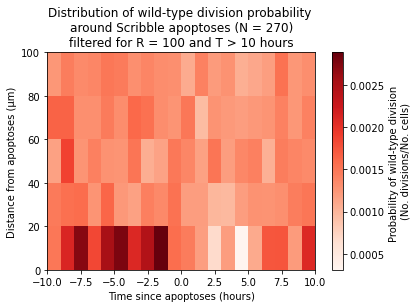

In [17]:
t_range = (-10,10)
R_max = 100
bins = (20, 5)
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 270)\nfiltered for R = 100 and T > 10 hours')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('', bbox_inches = 'tight')

# Control measures

### 1. Wild-type divisions around random wild-type points

I have some skepticism about this method as it seems too randomised, leading it to pick up some potential boundary effects of scanning in space and time, i.e. it's suspicious that the peaks in probability are repeated in near pre-apoptotic time.

### 2. Wild-type divisions around wild-type apoptoses

Processed

### 3. Wild-type divisions around Scr. apoptoses in uninduced experiments

Need to find Scr. apoptoses in uninduced experiments.

# Loading control measure #1

In [18]:
scan_dir = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600'

In [19]:
files = natsorted(glob.glob(f'{scan_dir}/*.csv'))
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [20]:
len(event_files)

7689

#### temp note: need to change path in function if using typical control

In [26]:
control_N_events_df = load_radial_df(event_files[0:1900],
                                    limit = 300,
                                    crop_amount = 20, 
                                    streamline = True, 
                                   strict_filtering= True) ### N_cells is large so streamlining advised

Loading control focal track information


  0%|          | 0/1900 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 480


In [27]:
control_N_cells_df = load_radial_df(cell_count_files[0:1900],# ) #no filtering
                                    limit = 300,
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised

Loading control focal track information


  0%|          | 0/1900 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 480


#### Plotting control #1

Text(0.5, 0, 'Time since apoptoses (hours)')

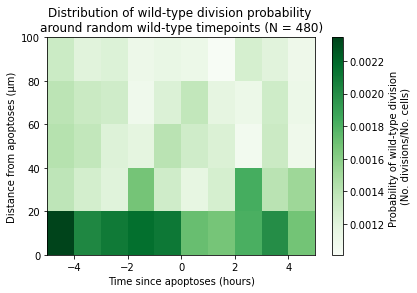

In [29]:
t_range = (-5,5)
R_max = 100
bins = (10, 5)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events_c.T, cmap = 'Greens', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround random wild-type timepoints (N = 480)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')


#### Plotting probability above background for control #1

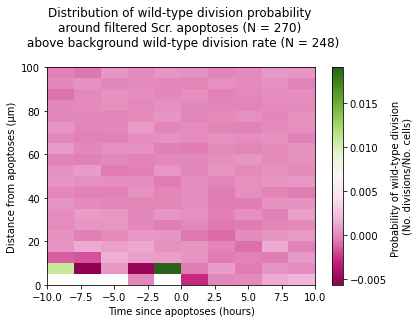

In [35]:
t_range = (-10,10)
R_max = 100
bins = (10,20)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

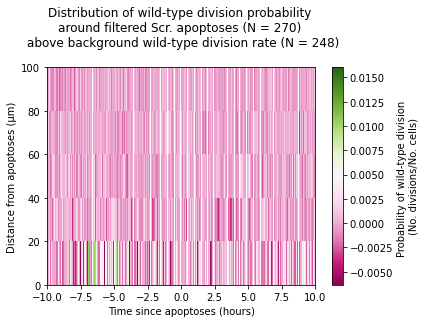

In [442]:
t_range = (-10,10)
R_max = 100
bins = (300, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine grained in time.pdf')

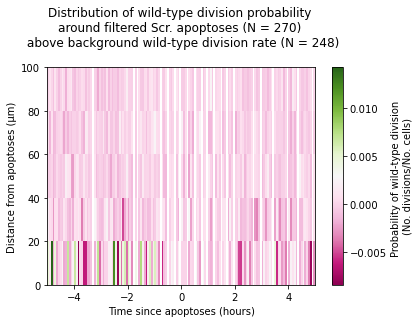

In [443]:
t_range = (-5,5)
R_max = 100
bins = (150, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -5-5hrs finely grained in time.pdf')

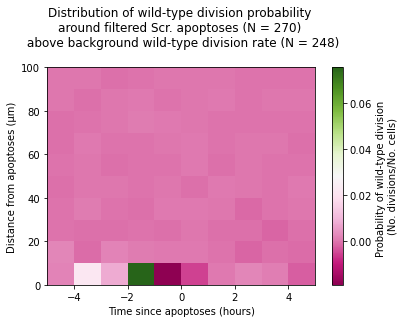

In [444]:
t_range = (-5,5)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -5-5hrs coarsely grained.pdf')

# Control measure #2 

### Wild-type divisions around wild-type apoptoses

In [30]:
control_2_file_path = '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600'

In [31]:
files = natsorted(glob.glob(f'{control_2_file_path}/*.csv'))
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [32]:
len(event_files)

385

In [33]:
event_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos3_wt_142_N_events_wt_rad_1600_t_range_1600_focal_txy_811_447_825.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos3_wt_311_N_events_wt_rad_1600_t_range_1600_focal_txy_731_259_1096.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos4_wt_393_N_events_wt_rad_1600_t_range_1600_focal_txy_766_1173_1456.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos5_wt_1_N_events_wt_rad_1600_t_range_1600_focal_txy_35_274_1395.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos7_wt_292_N_events_wt_rad_1600_t_range_1600_focal_txy_884_447_1576.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/

In [34]:
control_2_N_events_df = load_radial_df(event_files,# ) #no filtering
                                    limit = 300,
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised
control_2_N_cells_df = load_radial_df(cell_count_files,# ) #no filtering
                                    limit = 300,
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised

  0%|          | 0/385 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 105


  0%|          | 0/385 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 105


#### Plotting control #2

Text(0.5, 0, 'Time since apoptoses (hours)')

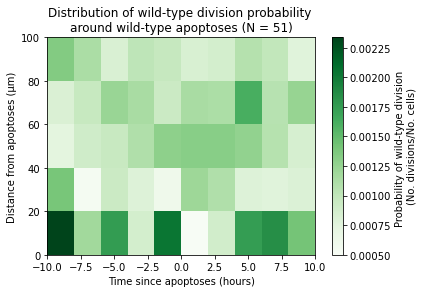

In [35]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events_c.T, cmap = 'Greens', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround wild-type apoptoses (N = 51)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr/wt_apop_wt_div probability cropped 0-100um -10-10hrs.pdf')

#### Plotting probability above background for control #2

Text(0.5, 0, 'Time since apoptoses (hours)')

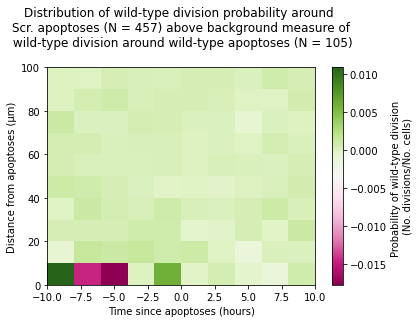

In [36]:
t_range = (-10,10)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 457) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

Text(0.5, 0, 'Time since apoptoses (hours)')

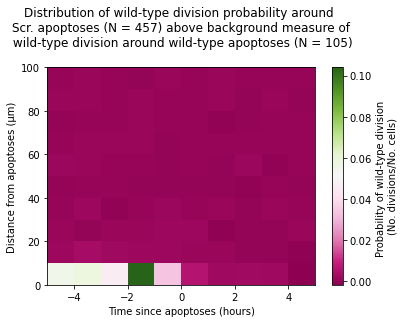

In [37]:
t_range = (-5,5)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 457) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

Text(0.5, 0, 'Time since apoptoses (hours)')

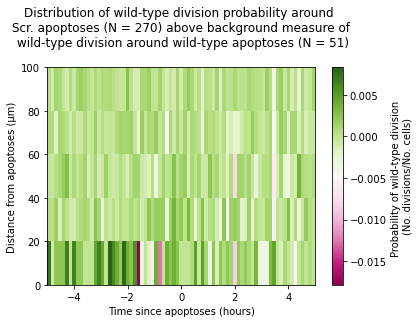

In [673]:
t_range = (-5,5)
R_max = 100
bins = (75,5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -5-5hrs finely grained in time.pdf', bbox_inches = 'tight')

Text(0.5, 0, 'Time since apoptoses (hours)')

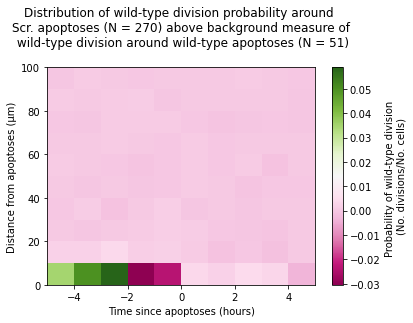

In [674]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -5-5hrs coarse grained.pdf', bbox_inches = 'tight')

# Sandbox

Text(0.5, 0, 'Time since apoptoses (hours)')

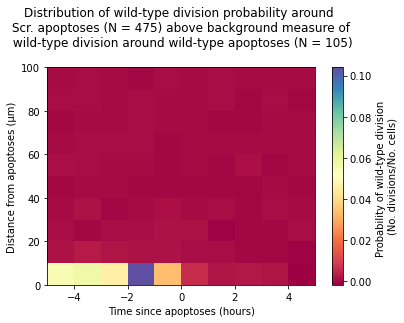

In [135]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 475) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

#### 1d plots of immediate local neighbourhood

Text(0.5, 0, 'Time since apoptoses (hours)')

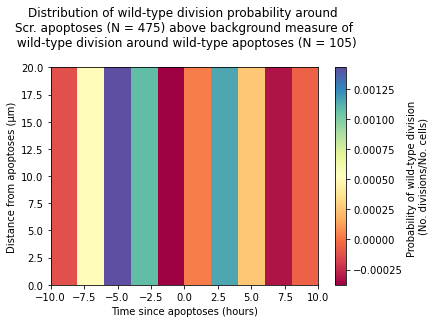

In [769]:
t_range = (-10,10)
R_max = 20
bins = (10,1)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 475) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

(0.0, 0.0019469821776246818)

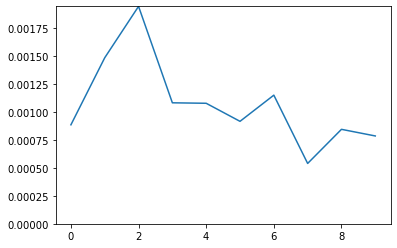

In [772]:
plt.plot(P_events)
plt.ylim(0,max(P_events))
#plt.xticks(xedges)

# Coefficient of variation



In [734]:
t_range = (-20,0)
R_max = 100
bins = (10,5)

P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

<Figure size 432x288 with 0 Axes>

In [39]:
import numpy as np

In [40]:
cv = np.nan_to_num(np.sqrt((1 - P_events) / (P_events * N_cells)), posinf=1)
# pc = plt.pcolormesh(xedges, yedges, cv.T, cmap = 'Spectral', )
# plt.colorbar(label = 'Coefficient of variation',)
# plt.title('Coefficient of variation for distribution of\n wild-type division probability around \nScr. apoptoses (N = 475)\n ')
# plt.ylabel('Distance from apoptoses (μm)')
# plt.xlabel('Time since apoptoses (hours)')

In [41]:
cv_c = np.nan_to_num(np.sqrt((1 - P_events_c) / (P_events_c * N_cells_c)), posinf=1)
# pc = plt.pcolormesh(xedges, yedges, cv_c.T, cmap = 'Spectral', )
# plt.colorbar(label = 'Coefficient of variation',)
# plt.title('Coefficient of variation for distribution of\n wild-type division probability around \nwild-type apoptoses (N = 105)\n ')
# plt.ylabel('Distance from apoptoses (μm)')
# plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

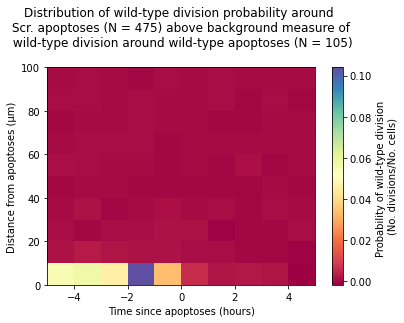

In [42]:
# P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
# P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 475) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

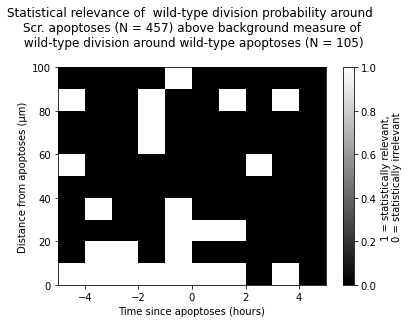

In [58]:
stat_rel = stat_relevance_calc(bins, P_events, P_events_c, cv, cv_c)
pc = plt.pcolormesh(xedges, yedges, stat_rel.T, cmap = 'gray', )
plt.colorbar(label = '1 = statistically relevant, \n0 = statistically irrelevant')
plt.title('Statistical relevance of  wild-type division probability around \nScr. apoptoses (N = 457) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

In [635]:
stat_rel.shape

(10, 5)

In [44]:
def stat_relevance_calc(num_bins, P_events, P_events_c, cv, cv_c):
    """
    Function that takes two probability arrays (canon and control), their associated coefficient of variation and calculates the statistical relevance of each bin
    """
    larger_than_array = np.zeros(bins)
    sig_dif_array = np.zeros(bins)
    for i, row in enumerate(P_events):
        for j, element in enumerate(row):
            P_div = P_events[i, j]
            P_div_control = P_events_c[i, j]
            if P_div > P_div_control:
                larger_than_array[i, j] = 1
                measure1 = P_div * (1 - cv[i, j])
                measure2 = P_div_control * (1 + cv_c[i, j])
                if measure1 > measure2:
                    # print(i,j, 'sig dif')
                    sig_dif_array[i, j] = 1
                else:
                    # print(i,j, 'NOT sig dif')
                    sig_dif_array[i, j] = 0
            elif (
                P_div == P_div_control == 0
            ):  ### if P_div is zero then that is bc there arent enough events counted and it is not statistically relevant
                sig_dif_array[i, j] = 0
            elif P_div < P_div_control:
                larger_than_array[i, j] = 0
                measure1 = P_div_control * (1 - cv_c[i, j])
                measure2 = P_div * (1 + cv[i, j])
                if measure1 > measure2:
                    # print(i,j, 'sig dif')
                    sig_dif_array[i, j] = 1
                else:
                    # print(i,j, 'NOT sig dif')
                    sig_dif_array[i, j] = 0
    #         else:
    #             print('Error calculating statistical relevance at index', i,j)
    return sig_dif_array

# what are the cell counts in the first spatial bins???

Text(0.5, 0, 'Time since apoptoses (hours)')

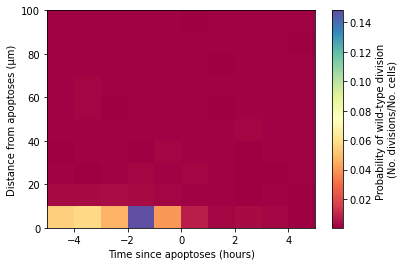

In [44]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)'
    )
#plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

Text(0.5, 0, 'Time since apoptoses (hours)')

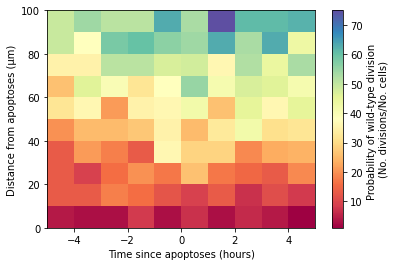

In [45]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)'
    )
#plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

Text(0.5, 0, 'Time since apoptoses (hours)')

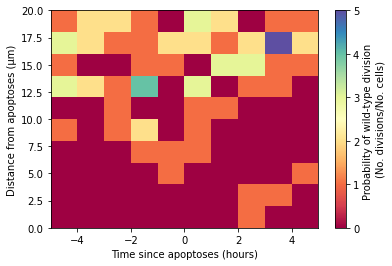

In [46]:
t_range = (-5,5)
R_max = 20
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)'
    )
#plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

Text(0.5, 0, 'Time since apoptoses (hours)')

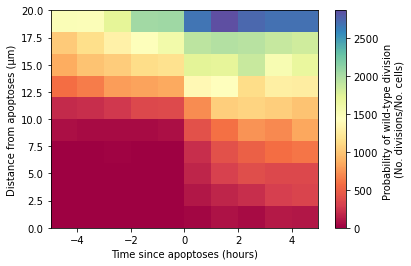

In [47]:
t_range = (-5,5)
R_max = 20
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, N_cells.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)'
    )
#plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

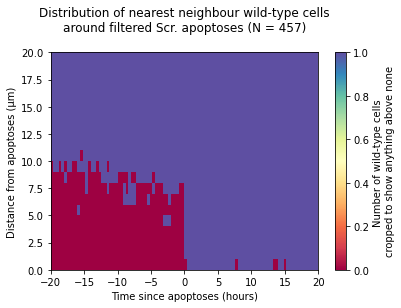

In [164]:
t_range = (-20,20)
R_max = 20
bins = (100,20)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, N_cells.T, cmap = 'Spectral', )
plt.colorbar(label = 'Number of wild-type cells \ncropped to show anything above none'
    )
plt.clim(0,1)
plt.title('Distribution of nearest neighbour wild-type cells\naround filtered Scr. apoptoses (N = 457)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/proofs/Distribution of nearest neighbour wild-type cells around filtered Scr. apoptoses (N = 457) -20-20hrs20um.pdf', bbox_inches = 'tight')

In [105]:
N_cells_df

,Distance from apoptosis,Time since apoptosis
0,359.666667,-31.266667
1,358.666667,-31.266667
2,157.666667,-31.266667
3,103.333333,-31.266667
4,110.333333,-31.266667
...,...,...
70331776,329.000000,3.733333
70331777,269.333333,3.733333
70331778,292.666667,3.733333
70331779,400.666667,3.733333


In [136]:
N_events_df = load_radial_df(event_files,#) ## no filtering 
                                    limit = 300,
                             crop_amount = 20, ### how much to crop the spatial measurements to avoid boundary effects
                             streamline = False, 
                            strict_filtering=True)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 457


In [137]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis,Focal event
0,23,124.666667,322,569,1311,-9.800000,GV0794_Pos4_6_RFP
1,22,122.666667,576,420,673,7.133333,GV0794_Pos4_6_RFP
2,21,79.666667,371,486,784,-6.533333,GV0794_Pos4_6_RFP
3,20,315.000000,324,391,46,-9.666667,GV0794_Pos4_6_RFP
4,19,134.333333,376,416,622,-6.200000,GV0794_Pos4_6_RFP
...,...,...,...,...,...,...,...
98365,1262,154.666667,1036,949,1504,3.533333,GV0820_Pos5_445_RFP
98366,1276,272.000000,967,20,1157,-1.066667,GV0820_Pos5_445_RFP
98367,1313,109.000000,1033,1107,878,3.333333,GV0820_Pos5_445_RFP
98368,1393,235.333333,990,340,1563,0.466667,GV0820_Pos5_445_RFP


In [151]:
for fn in event_files:
    if 'GV0807_Pos4_Scr_-556' in fn:
        print(fn)

In [144]:
for i in N_events_df.index:
    
    if N_events_df['Distance from apoptosis'][i] < 12:
        if N_events_df['Time since apoptosis'][i] < 0:
            print(N_events_df.loc[i])

Cell ID                                   1871
Distance from apoptosis                   11.0
Frame                                     1124
x                                          681
y                                         1137
Time since apoptosis                 -0.133333
Focal event                GV0807_Pos4_377_RFP
Name: 68153, dtype: object
Cell ID                                    890
Distance from apoptosis              10.666667
Frame                                      919
x                                          718
y                                          893
Time since apoptosis                      -8.2
Focal event                GV0807_Pos4_381_RFP
Name: 68335, dtype: object
Cell ID                                    468
Distance from apoptosis              11.666667
Frame                                      795
x                                          316
y                                          767
Time since apoptosis                     -19.0
Focal 

In [146]:
for i in N_cells_df.index:
    if N_cells_df['Distance from apoptosis'][i] < 5:
        if N_cells_df['Time since apoptosis'][i] < 0:
            print(N_cells_df.loc[i])

Distance from apoptosis    4.666667
Time since apoptosis      -2.400000
Name: 23666355, dtype: float64
Distance from apoptosis    4.333333
Time since apoptosis      -2.333333
Name: 23666742, dtype: float64
Distance from apoptosis    4.666667
Time since apoptosis      -3.000000
Name: 36037520, dtype: float64
